In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, BatchNorm
from torch_geometric.data import Data
import matplotlib.pyplot as plt

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cuda


### Data Load & Analysis

In [5]:
data = torch.load('data/processed_data/graph_data.pt').to(device)

In [6]:
input_dim = data.num_features
output_dim = len(torch.unique(data.y))

In [7]:
num_nodes = data.num_nodes
num_train = int(num_nodes * 0.8)
num_val = int(num_nodes * 0.1)
num_test = num_nodes - (num_train + num_val)

indices = torch.randperm(num_nodes)

train_mask = indices[:num_train]
val_mask = indices[num_train:num_train + num_val]
test_mask = indices[num_train + num_val:]

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool).scatter_(0, train_mask, True)
data.val_mask = torch.zeros(num_nodes, dtype=torch.bool).scatter_(0, val_mask, True)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool).scatter_(0, test_mask, True)


In [8]:
unique_labels = data.y.unique()
print(unique_labels)  
output_dim = len(unique_labels)


tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


In [9]:
data.x = (data.x - data.x.mean(dim=0)) / data.x.std(dim=0)

In [10]:
print(data.train_mask.sum(), data.val_mask.sum(), data.test_mask.sum())
print(data.y.min(), data.y.max())


tensor(297746) tensor(37218) tensor(37219)
tensor(0, device='cuda:0') tensor(8, device='cuda:0')


In [11]:
assert data.y.min() >= 0 and data.y.max() < output_dim
assert torch.isfinite(data.x).all()
assert torch.isfinite(data.y).all()


In [12]:
print(data)
print(data.edge_index.size())
print(data.x.size())
print(data.y.size())


Data(x=[372183, 102], edge_index=[2, 1199750], y=[372183], train_mask=[372183], val_mask=[372183], test_mask=[372183])
torch.Size([2, 1199750])
torch.Size([372183, 102])
torch.Size([372183])


In [13]:
for i in range(output_dim):
    print(f"Class {i}: {(data.y == i).sum().item()} instances")


Class 0: 1 instances
Class 1: 273001 instances
Class 2: 17918 instances
Class 3: 63084 instances
Class 4: 3 instances
Class 5: 1 instances
Class 6: 7 instances
Class 7: 18167 instances
Class 8: 1 instances


### Model

In [14]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, dropout_rate):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim1)
        self.bn1 = BatchNorm(hidden_dim1)
        self.conv2 = GCNConv(hidden_dim1, hidden_dim2)
        self.bn2 = BatchNorm(hidden_dim2)
        self.conv3 = GCNConv(hidden_dim2, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=dropout_rate, training=self.training)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=dropout_rate, training=self.training)

        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)


### Hyperparameters

In [15]:
hidden_dim1 = 32
hidden_dim2 = 16

dropout_rate = 0.5
lr=0.1
weight_decay=5e-3
step_size=50
gamma=0.5


class_weights = torch.tensor([1, 0.1, 10, 5, 20, 30, 15, 10, 30], device=device)

def weights_init(m):
    if hasattr(m, 'weight') and m.weight is not None:
            torch.nn.init.xavier_uniform_(m.weight)
    if hasattr(m, 'bias') and m.bias is not None:
        torch.nn.init.zeros_(m.bias)

In [17]:
model = GCN(input_dim=input_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, output_dim=output_dim, dropout_rate=dropout_rate).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)



def weights_init(m):
    if hasattr(m, 'weight') and m.weight is not None:
            torch.nn.init.xavier_uniform_(m.weight)
    if hasattr(m, 'bias') and m.bias is not None:
        torch.nn.init.zeros_(m.bias)


### Training & Eval

In [18]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])

    loss.backward()
    
    for name, param in model.named_parameters():
        if param.grad is not None:
            print(f"{name}, gradient norm: {param.grad.norm().item()}")
        else:
            print(f"{name} has no gradient")

    optimizer.step()
    return loss.item()


def test():
    model.eval()
    logits = model(data)
    loss_fn = torch.nn.NLLLoss()
    
    accs = []
    losses = []
    
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        mask_logits = logits[mask]
        mask_labels = data.y[mask]
        loss = loss_fn(mask_logits, mask_labels)
        pred = mask_logits.max(1)[1]
        acc = pred.eq(mask_labels).sum().item() / mask.sum().item()
        accs.append(acc)
        losses.append(loss.item())
    
    return accs[0], accs[1], accs[2], losses[1]


In [19]:
epochs = 500
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

for epoch in range(epochs):
    train_loss = train()
    training_losses.append(train_loss)
    scheduler.step()
    
    train_acc, val_acc, test_acc, val_loss = test()
    training_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)
    validation_losses.append(val_loss)
    
    print(f'Epoch: {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')




conv1.bias, gradient norm: 8.232212245218307e-09
conv1.lin.weight, gradient norm: 2.318267822265625
bn1.module.weight, gradient norm: 0.21683312952518463
bn1.module.bias, gradient norm: 0.1841115802526474
conv2.bias, gradient norm: 9.956223578910794e-08
conv2.lin.weight, gradient norm: 1.1698213815689087
bn2.module.weight, gradient norm: 0.5124688744544983
bn2.module.bias, gradient norm: 0.6276944279670715
conv3.bias, gradient norm: 0.5349704623222351
conv3.lin.weight, gradient norm: 1.1349483728408813
Epoch: 1, Training Loss: 3.2093, Validation Loss: 2.4981, Train Acc: 0.1603, Val Acc: 0.1625, Test Acc: 0.1578
conv1.bias, gradient norm: 3.0504065939851444e-09
conv1.lin.weight, gradient norm: 0.37072664499282837
bn1.module.weight, gradient norm: 0.14312463998794556
bn1.module.bias, gradient norm: 0.14479804039001465
conv2.bias, gradient norm: 2.9778274068803512e-08
conv2.lin.weight, gradient norm: 0.4813706576824188
bn2.module.weight, gradient norm: 0.13805237412452698
bn2.module.bias,

### Plots

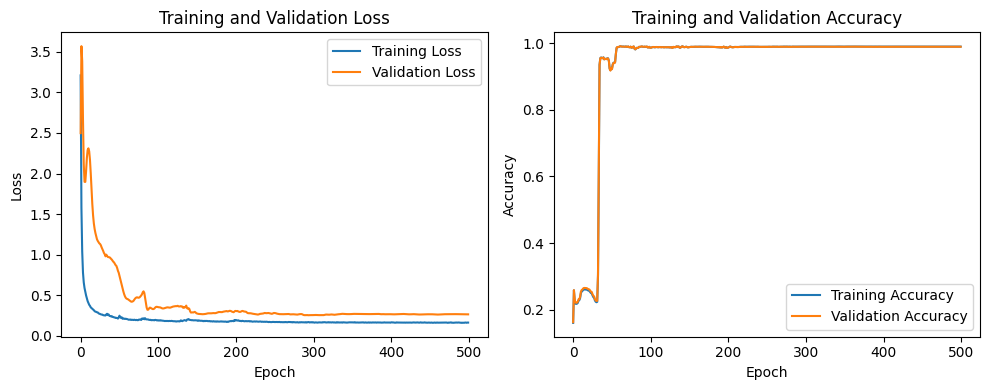

In [20]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
